In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data.csv')
df.dropna(subset=['price'], inplace=True)
df.reset_index(drop=True, inplace=True)

In [3]:
features = list(df.columns)
target = 'price'
features.remove(target)

X = df[features]
y = df[target].str.strip("$").str.replace(",","").astype(float)

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
class Data_Transformer(object):
    
    def fit(self, X, y=None):
        new_df = pd.DataFrame()
        new_df["Weight"] = X["weight"].map(self.weight2num) # convert weight to numerical value
        self.mean_weight = new_df["Weight"].mean() # obtain mean weight
        new_df["Weight"].fillna(self.mean_weight,inplace=True) # fill in missing weight with mean weight
        new_df["Month"] = pd.to_datetime(X["purchase_date"]).dt.month # convert purchase date to purchase weekday
        self.majority_month = new_df["Month"].mode()[0] # obtain majority purchase month
        new_df["Month"].fillna(self.majority_month,inplace=True) # fill in missing purchase month with majority purchase month
        new_df["Weekday"] = pd.to_datetime(X["purchase_date"]).dt.weekday # convert purchase date to purchase weekday
        self.majority_weekday = new_df["Weekday"].mode()[0] # obtain majority purchase weekday
        new_df["Weekday"].fillna(self.majority_weekday,inplace=True) # fill in missing purchase weekday with majority purchase weekday
        new_df["Ingredient Number"] = X["ingredient"].map(self.get_numbers) # obtain number of ingredients in recipe
        self.mean_ingredient_number = new_df["Ingredient Number"].mean() # obtain mean ingredient number
        new_df['Ingredient Number'].fillna(self.mean_ingredient_number,inplace=True) # fill in missing ingredient number with median ingredient number
        self.pl_le = LabelEncoder() # create label-encoder
        new_df["Product Level"] = pd.Series(self.pl_le.fit_transform(X["product_level"])) # fit and transform product level with label-encoder
        self.majority_product_level = new_df["Product Level"].mode()[0] # obtain majority product level code
        new_df["Product Level"].fillna(self.majority_product_level,inplace=True) # fill in missing product level with majority product level code
        self.pt_le = LabelEncoder() # create label-encoder
        new_df["Cost"] = X["cost"].str.strip("$").str.strip("k").astype(float)*1000 # convert cost to numerical value
        self.cost_imputer = XGBRegressor() # create a XGBoost imputer for cost
        df_for_imputing_cost = new_df.dropna() # create training data for cost imputer by dropping missing data
        self.cost_imputer.fit(df_for_imputing_cost[["Weight","Month","Weekday","Ingredient Number","Product Level"]], df_for_imputing_cost["Cost"]) # fit cost imputer
        
    def transform(self, X, y=None):
        new_df = pd.DataFrame()
        new_df["Weight"] = X["weight"].map(self.weight2num) # convert weight to numerical value
        new_df["Weight"].fillna(self.mean_weight,inplace=True) # fill in missing weight with mean weight
        new_df["Month"] = pd.to_datetime(X["purchase_date"]).dt.month # convert purchase date to purchase month
        new_df["Month"].fillna(self.majority_month,inplace=True) # fill in missing purchase month with majority purchase month
        new_df["Weekday"] = pd.to_datetime(X["purchase_date"]).dt.weekday # convert purchase date to purchase weekday
        new_df["Weekday"].fillna(self.majority_weekday,inplace=True) # fill in missing purchase weekday with majority purchase weekday
        new_df['Ingredient Number'] = X["ingredient"].map(self.get_numbers) # obtain number of ingredients in recipe
        new_df['Ingredient Number'].fillna(self.mean_ingredient_number,inplace=True) # fill in missing ingredient number with mean ingredient number
        new_df["Product Level"] = self.pl_le.transform(X["product_level"]) # transform product level with label-encoder
        new_df["Product Level"].fillna(self.majority_product_level,inplace=True) # fill in missing product level with majority product level code
        new_df["Cost"] = X["cost"].str.strip("$").str.strip("k").astype(float)*1000 # convert cost to numerical value
        imputed_cost = pd.Series(self.cost_imputer.predict(new_df[new_df["Cost"].isnull()][["Weight","Month","Weekday","Ingredient Number","Product Level"]])) # obtain imputed cost
        imputed_cost.index = new_df[new_df["Cost"].isnull()]["Cost"].index # set index of imputed cost
        new_df["Cost"].fillna(imputed_cost,inplace=True) # fill in missing cost with imputed cost
        return new_df # return new_df
    
    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)
    
    def weight2num(self, x): # function to convert weight to number
        if type(x) == str:
            x = x.strip('Kg').split(' Ton ')
            return float(x[0])*1000+float(x[1])
        else:
            return x
        
    def get_numbers(self, x): # function to get number of ingredients in recipe
        if type(x) == str:
            return len(x.split(','))
        else:
            return x

## 1. Random Rorest Regressor

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, r2_score

In [7]:
steps = [('dtf', Data_Transformer()),
         ('rf', RandomForestRegressor(n_jobs=-1))]
rf_model = Pipeline(steps)

In [8]:
parameters = {'rf__max_depth': [3, 4, 5, 7, 9, 12], 
              'rf__min_samples_leaf': [2, 5, 10],
              'rf__min_samples_split': [2, 5, 10],
              'rf__n_estimators': [100, 200]}
scorer = make_scorer(r2_score, greater_is_better=True)

In [9]:
model_gsv = GridSearchCV(rf_model, parameters, cv=5, scoring=scorer)
model_gsv = model_gsv.fit(X_train, y_train)

In [10]:
model_gsv.best_params_

{'rf__max_depth': 5,
 'rf__min_samples_leaf': 5,
 'rf__min_samples_split': 2,
 'rf__n_estimators': 200}

In [11]:
result = model_gsv.cv_results_
result = pd.DataFrame(result)[['param_rf__max_depth', 'param_rf__min_samples_leaf','param_rf__min_samples_split', 'param_rf__n_estimators', 'mean_test_score', 'rank_test_score']]
result

,param_rf__max_depth,param_rf__min_samples_leaf,param_rf__min_samples_split,param_rf__n_estimators,mean_test_score,rank_test_score
0,3,2,2,100,0.370733,92
1,3,2,2,200,0.370299,94
2,3,2,5,100,0.366027,104
3,3,2,5,200,0.368120,100
4,3,2,10,100,0.367896,101
...,...,...,...,...,...,...
103,12,10,2,200,0.383436,67
104,12,10,5,100,0.381637,70
105,12,10,5,200,0.384913,55
106,12,10,10,100,0.384819,57


In [12]:
y_train_pred = model_gsv.predict(X_train)
y_test_pred = model_gsv.predict(X_test)

In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [14]:
print('train MAE: {0:.2e}'.format(mean_absolute_error(y_train, y_train_pred)))
print('train MSE: {0:.2e}'.format(mean_squared_error(y_train, y_train_pred)))
print('train R2: {0:.3f}'.format(r2_score(y_train, y_train_pred)))

train MAE: 1.01e+05
train MSE: 2.42e+10
train R2: 0.522


In [15]:
print('test MAE: {0:.2e}'.format(mean_absolute_error(y_test, y_test_pred)))
print('test MSE: {0:.2e}'.format(mean_squared_error(y_test, y_test_pred)))
print('test R2: {0:.3f}'.format(r2_score(y_test, y_test_pred)))

test MAE: 1.05e+05
test MSE: 2.31e+10
test R2: 0.428


([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'Weight'),
  Text(1, 0, 'Month'),
  Text(2, 0, 'Weekday'),
  Text(3, 0, 'Ingredient Number'),
  Text(4, 0, 'Product Level'),
  Text(5, 0, 'Cost')])

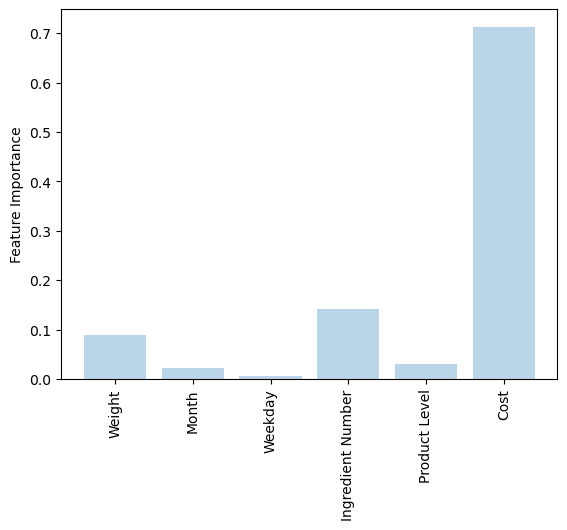

In [16]:
plt.bar(model_gsv.best_estimator_.steps[0][1].transform(X_train).columns, model_gsv.best_estimator_.steps[1][1].feature_importances_,alpha=0.3)
plt.ylabel("Feature Importance")
plt.xticks(rotation=90)

## 2. Gradient Boosting Regressor

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import make_scorer, r2_score

In [18]:
steps = [('dtf', Data_Transformer()),
         ('gbr', GradientBoostingRegressor())]
gbr_model = Pipeline(steps)

In [19]:
parameters = {'gbr__learning_rate': [0.05, 0.1], 
              'gbr__n_estimators': [100, 200], 
              'gbr__max_depth': [3, 5, 10], 
              'gbr__min_samples_leaf': [2, 5, 10], 
              'gbr__min_samples_split': [2, 5, 10]}
scorer = make_scorer(r2_score, greater_is_better=True)

In [20]:
model_gsv = GridSearchCV(gbr_model, parameters, cv=5, scoring=scorer)
model_gsv = model_gsv.fit(X_train, y_train)

In [21]:
model_gsv.best_params_

{'gbr__learning_rate': 0.05,
 'gbr__max_depth': 3,
 'gbr__min_samples_leaf': 10,
 'gbr__min_samples_split': 2,
 'gbr__n_estimators': 100}

In [22]:
result = model_gsv.cv_results_
result = pd.DataFrame(result)[['param_gbr__learning_rate', 'param_gbr__n_estimators','param_gbr__max_depth', 'param_gbr__min_samples_leaf', 'param_gbr__min_samples_split', 'mean_test_score', 'rank_test_score']]
result

,param_gbr__learning_rate,param_gbr__n_estimators,param_gbr__max_depth,param_gbr__min_samples_leaf,param_gbr__min_samples_split,mean_test_score,rank_test_score
0,0.05,100,3,2,2,0.399529,20
1,0.05,200,3,2,2,0.386398,26
2,0.05,100,3,2,5,0.400777,10
3,0.05,200,3,2,5,0.389946,25
4,0.05,100,3,2,10,0.395856,24
...,...,...,...,...,...,...,...
103,0.1,200,10,10,2,0.306503,81
104,0.1,100,10,10,5,0.344037,67
105,0.1,200,10,10,5,0.306503,79
106,0.1,100,10,10,10,0.344037,67


In [23]:
y_train_pred = model_gsv.predict(X_train)
y_test_pred = model_gsv.predict(X_test)

In [24]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [25]:
print('train MAE: {0:.2e}'.format(mean_absolute_error(y_train, y_train_pred)))
print('train MSE: {0:.2e}'.format(mean_squared_error(y_train, y_train_pred)))
print('train R2: {0:.3f}'.format(r2_score(y_train, y_train_pred)))

train MAE: 1.00e+05
train MSE: 2.41e+10
train R2: 0.525


In [26]:
print('test MAE: {0:.2e}'.format(mean_absolute_error(y_test, y_test_pred)))
print('test MSE: {0:.2e}'.format(mean_squared_error(y_test, y_test_pred)))
print('test R2: {0:.3f}'.format(r2_score(y_test, y_test_pred)))

test MAE: 1.06e+05
test MSE: 2.36e+10
test R2: 0.418


([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'Weight'),
  Text(1, 0, 'Month'),
  Text(2, 0, 'Weekday'),
  Text(3, 0, 'Ingredient Number'),
  Text(4, 0, 'Product Level'),
  Text(5, 0, 'Cost')])

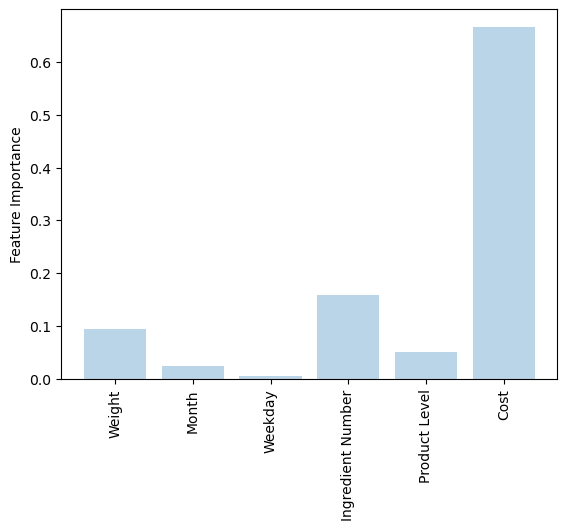

In [27]:
plt.bar(model_gsv.best_estimator_.steps[0][1].transform(X_train).columns, model_gsv.best_estimator_.steps[1][1].feature_importances_,alpha=0.3)
plt.ylabel("Feature Importance")
plt.xticks(rotation=90)

## 3. XGBoost Regressor

In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer, r2_score

In [29]:
steps = [('dtf', Data_Transformer()),
         ('xgbr', XGBRegressor(n_jobs=6))]
xg_model = Pipeline(steps)

In [30]:
parameters = {'xgbr__gamma': [0.0, 0.1, 0.2, 0.3], 
              'xgbr__learning_rate': [0.05, 0.1], 
              'xgbr__n_estimators': [100, 200], 
              'xgbr__max_depth': [3, 5, 10], 
              'xgbr__lambda': [0.5, 1, 5], 
              'xgbr__min_child_weight': [3, 5, 7]}
scorer = make_scorer(r2_score, greater_is_better=True)

In [31]:
model_gsv = GridSearchCV(xg_model, parameters, cv=2, scoring=scorer)
model_gsv = model_gsv.fit(X_train, y_train)

In [32]:
model_gsv.best_params_

{'xgbr__gamma': 0.0,
 'xgbr__lambda': 1,
 'xgbr__learning_rate': 0.05,
 'xgbr__max_depth': 3,
 'xgbr__min_child_weight': 3,
 'xgbr__n_estimators': 100}

In [33]:
result = model_gsv.cv_results_
result = pd.DataFrame(result)[['param_xgbr__gamma', 'param_xgbr__learning_rate', 'param_xgbr__n_estimators', 'param_xgbr__max_depth', 'param_xgbr__lambda', 'param_xgbr__min_child_weight', 'mean_test_score', 'rank_test_score']]
result

,param_xgbr__gamma,param_xgbr__learning_rate,param_xgbr__n_estimators,param_xgbr__max_depth,param_xgbr__lambda,param_xgbr__min_child_weight,mean_test_score,rank_test_score
0,0.0,0.05,100,3,0.5,3,0.392410,17
1,0.0,0.05,200,3,0.5,3,0.374097,105
2,0.0,0.05,100,3,0.5,5,0.388623,33
3,0.0,0.05,200,3,0.5,5,0.374053,109
4,0.0,0.05,100,3,0.5,7,0.393761,5
...,...,...,...,...,...,...,...,...
427,0.3,0.1,200,10,5,3,0.280902,365
428,0.3,0.1,100,10,5,5,0.296579,317
429,0.3,0.1,200,10,5,5,0.257849,401
430,0.3,0.1,100,10,5,7,0.299439,313


In [34]:
y_train_pred = model_gsv.predict(X_train)
y_test_pred = model_gsv.predict(X_test)

In [35]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [36]:
print('train MAE: {0:.2e}'.format(mean_absolute_error(y_train, y_train_pred)))
print('train MSE: {0:.2e}'.format(mean_squared_error(y_train, y_train_pred)))
print('train R2: {0:.3f}'.format(r2_score(y_train, y_train_pred)))

train MAE: 9.93e+04
train MSE: 2.34e+10
train R2: 0.538


In [37]:
print('test MAE: {0:.2e}'.format(mean_absolute_error(y_test, y_test_pred)))
print('test MSE: {0:.2e}'.format(mean_squared_error(y_test, y_test_pred)))
print('test R2: {0:.3f}'.format(r2_score(y_test, y_test_pred)))

test MAE: 1.05e+05
test MSE: 2.31e+10
test R2: 0.429


([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'Weight'),
  Text(1, 0, 'Month'),
  Text(2, 0, 'Weekday'),
  Text(3, 0, 'Ingredient Number'),
  Text(4, 0, 'Product Level'),
  Text(5, 0, 'Cost')])

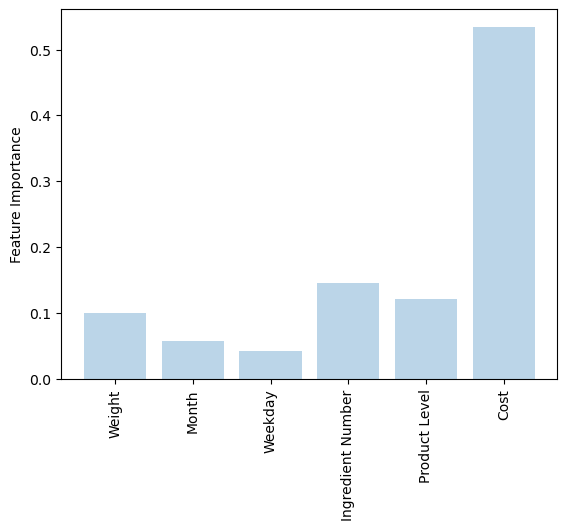

In [38]:
plt.bar(model_gsv.best_estimator_.steps[0][1].transform(X_train).columns, model_gsv.best_estimator_.steps[1][1].feature_importances_,alpha=0.3)
plt.ylabel("Feature Importance")
plt.xticks(rotation=90)